In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [2]:
time_diary = pd.read_stata("C:/Users/39348/Downloads/data/td_ita.dta")
questionnaire = pd.read_stata("C:/Users/39348/Downloads/data/data4diarynew_ITA.dta")

In [3]:
print(len(time_diary))
print(time_diary.id.nunique())

268474
241


In [5]:
# Define the cutoff date and time
cutoff_datetime = pd.to_datetime("2020-11-30 5:00:00")
cutoff_datetime2 = pd.to_datetime("2020-11-14 4:30:00")

# Filter the DataFrame to keep only rows where 'date_not' is earlier than the cutoff
time_diary = time_diary[time_diary['date_not'] < cutoff_datetime]
time_diary = time_diary[time_diary['date_not'] > cutoff_datetime2]

# Display the result to verify that all later dates have been removed
print(time_diary.date_not.head(1).item())
print(time_diary.date_not.tail(1).item())

2020-11-14 05:00:00
2020-11-30 04:30:00


In [99]:
# Convert 'date_not' to datetime if it's not already
time_diary['date_not'] = pd.to_datetime(time_diary['date_not'])

# Shift 'date_not' by 5 hours to adjust the day boundary
time_diary['date_adjusted'] = time_diary['date_not'] - pd.Timedelta(hours=5)

# Extract just the date part from the adjusted timestamp to use as the new "day"
time_diary['date'] = time_diary['date_adjusted'].dt.date

time_diary['time'] = time_diary['date_not'].dt.time

time_diary['datetime'] = pd.to_datetime(time_diary['date'].astype(str) + ' ' + time_diary['time'].astype(str))

# Check the results
print(time_diary[['date_not', 'datetime', 'date']].loc[152:155])

               date_not            datetime        date
152 2020-11-16 04:00:00 2020-11-15 04:00:00  2020-11-15
153 2020-11-16 04:30:00 2020-11-15 04:30:00  2020-11-15
154 2020-11-16 05:00:00 2020-11-16 05:00:00  2020-11-16
155 2020-11-16 05:30:00 2020-11-16 05:30:00  2020-11-16


In [100]:
# Ensure the columns 'id' and 'date_adjusted' are in datetime format if necessary
time_diary['date'] = pd.to_datetime(time_diary['date'])

# Group by 'id' and 'date_adjusted' to create a single DataFrame that aligns 'howwasday' and 'expectday'
df = time_diary.groupby(['id', 'date']).agg({
    'expectday': 'first',
    'howwasday': 'first'
}).reset_index()

# Check the structure to ensure alignment
df

,id,date,expectday,howwasday
0,0.0,2020-11-14,Happy,4.0
1,0.0,2020-11-15,4.0,4.0
2,0.0,2020-11-16,No information,4.0
3,0.0,2020-11-17,4.0,4.0
4,0.0,2020-11-18,No information,4.0
...,...,...,...,...
3851,266.0,2020-11-25,No information,Happy
3852,266.0,2020-11-26,Happy,No information
3853,266.0,2020-11-27,No information,Happy
3854,266.0,2020-11-28,Happy,Happy


In [101]:
# Define a mapping for the categories, converting non-numeric to NaN
day_evaluation_mapping = {
    'Sad': 1,
    2.0: 2,
    3.0: 3,
    4.0: 4,
    'Happy': 5,
    'No information': np.nan,
    'Not answer': np.nan,
    'Expired': np.nan
}

# Map the categories in the 'howwasday' and 'expectday' columns
df['expectday_numeric'] = df['expectday'].map(day_evaluation_mapping)
df['howwasday_numeric'] = df['howwasday'].map(day_evaluation_mapping)

df = df.dropna(subset=['expectday_numeric', 'howwasday_numeric'])

df

,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric
0,0.0,2020-11-14,Happy,4.0,5.0,4.0
1,0.0,2020-11-15,4.0,4.0,4.0,4.0
3,0.0,2020-11-17,4.0,4.0,4.0,4.0
5,0.0,2020-11-19,Happy,3.0,5.0,3.0
6,0.0,2020-11-20,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...
3847,266.0,2020-11-21,Happy,Happy,5.0,5.0
3849,266.0,2020-11-23,Happy,Happy,5.0,5.0
3850,266.0,2020-11-24,4.0,4.0,4.0,4.0
3854,266.0,2020-11-28,Happy,Happy,5.0,5.0


In [102]:
df.id.value_counts()

114.0    16
27.0     16
58.0     16
163.0    16
169.0    16
         ..
23.0      1
159.0     1
182.0     1
173.0     1
87.0      1
Name: id, Length: 194, dtype: int64

In [103]:
#under 10 responses
ids_to_remove = [
    76.0, 86.0, 131.0, 227.0, 24.0, 74.0, 41.0, 83.0, 113.0, 12.0,
    5.0, 187.0, 195.0, 233.0, 196.0, 50.0, 21.0, 224.0, 91.0, 243.0,
    217.0, 151.0, 179.0, 164.0, 185.0, 188.0, 124.0, 252.0, 94.0, 42.0,
    62.0, 52.0, 210.0, 212.0, 84.0, 85.0, 157.0, 256.0, 30.0, 45.0,
    53.0, 165.0, 90.0, 214.0, 49.0, 35.0, 14.0, 115.0, 51.0, 80.0,
    107.0, 106.0, 95.0, 92.0, 180.0, 120.0, 104.0, 139.0, 140.0, 242.0,
    48.0, 238.0, 72.0, 37.0, 33.0, 68.0, 219.0, 110.0, 9.0, 125.0,
    220.0, 204.0, 201.0, 137.0, 75.0, 232.0, 102.0, 17.0, 184.0, 228.0,
    23.0, 159.0, 182.0, 173.0, 87.0
]

# Remove rows where 'id' is in the list
df = df[~df['id'].isin(ids_to_remove)]

df

,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric
0,0.0,2020-11-14,Happy,4.0,5.0,4.0
1,0.0,2020-11-15,4.0,4.0,4.0,4.0
3,0.0,2020-11-17,4.0,4.0,4.0,4.0
5,0.0,2020-11-19,Happy,3.0,5.0,3.0
6,0.0,2020-11-20,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...
3847,266.0,2020-11-21,Happy,Happy,5.0,5.0
3849,266.0,2020-11-23,Happy,Happy,5.0,5.0
3850,266.0,2020-11-24,4.0,4.0,4.0,4.0
3854,266.0,2020-11-28,Happy,Happy,5.0,5.0


In [104]:
# Standardize 'expectday_numeric' for each participant
df['expectday_standardized'] = df.groupby('id')['expectday_numeric'].transform(
    lambda x: (x - x.mean()) / x.std()  
)

# Standardize 'howwasday_numeric' for each participant
df['howwasday_standardized'] = df.groupby('id')['howwasday_numeric'].transform(
    lambda x: (x - x.mean()) / x.std()   
)

df

C:\Users\39348\AppData\Local\Temp\ipykernel_13760\4141027352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['expectday_standardized'] = df.groupby('id')['expectday_numeric'].transform(
C:\Users\39348\AppData\Local\Temp\ipykernel_13760\4141027352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['howwasday_standardized'] = df.groupby('id')['howwasday_numeric'].transform(


,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric,expectday_standardized,howwasday_standardized
0,0.0,2020-11-14,Happy,4.0,5.0,4.0,2.140872,0.000000
1,0.0,2020-11-15,4.0,4.0,4.0,4.0,-0.428174,0.000000
3,0.0,2020-11-17,4.0,4.0,4.0,4.0,-0.428174,0.000000
5,0.0,2020-11-19,Happy,3.0,5.0,3.0,2.140872,-2.345208
6,0.0,2020-11-20,4.0,4.0,4.0,4.0,-0.428174,0.000000
...,...,...,...,...,...,...,...,...
3847,266.0,2020-11-21,Happy,Happy,5.0,5.0,0.288675,0.288675
3849,266.0,2020-11-23,Happy,Happy,5.0,5.0,0.288675,0.288675
3850,266.0,2020-11-24,4.0,4.0,4.0,4.0,-3.175426,-3.175426
3854,266.0,2020-11-28,Happy,Happy,5.0,5.0,0.288675,0.288675


In [105]:
df = df.dropna()

df.isnull().sum().sum()

0

In [106]:
# Convert 'date_not' to datetime if it's not already
time_diary['date_adjusted'] = pd.to_datetime(time_diary['date_adjusted'])

# Define the list of holidays
holidays = [
    pd.to_datetime("2020-11-14"),
    pd.to_datetime("2020-11-15"),
    pd.to_datetime("2020-11-21"),
    pd.to_datetime("2020-11-22"),
    pd.to_datetime("2020-11-28"),
    pd.to_datetime("2020-11-29")
]

# Create a new column 'is_holiday' that is True if the date is a holiday, else False
time_diary['is_holiday'] = time_diary['date_adjusted'].dt.date.isin([date.date() for date in holidays])

# Convert the boolean to a more descriptive label (e.g., 'Holiday' and 'Workday')
time_diary['day_type'] = time_diary['is_holiday'].apply(lambda x: 'Holiday' if x else 'Workday')

time_diary['day_of_week'] = time_diary['date_adjusted'].dt.day_name()

# Check the results
print(time_diary[['date', 'day_type', 'day_of_week']].loc[153:154])

          date day_type day_of_week
153 2020-11-15  Holiday      Sunday
154 2020-11-16  Workday      Monday


In [107]:
# Ensure 'id' and 'date' are in datetime format if necessary
time_diary['date'] = pd.to_datetime(time_diary['date'])
df['date'] = pd.to_datetime(df['date'])

# Select only the unique rows from time_diary with the necessary columns
columns_to_add = time_diary[['id', 'date', 'day_type', 'day_of_week']].drop_duplicates(subset=['id', 'date'])

# Merge the unique rows with df using 'id' and 'date' as keys
df = pd.merge(df, columns_to_add, on=['id', 'date'], how='outer')

df

C:\Users\39348\AppData\Local\Temp\ipykernel_13760\3334315682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric,expectday_standardized,howwasday_standardized,day_type,day_of_week
0,0.0,2020-11-14,Happy,4.0,5.0,4.0,2.140872,0.000000,Holiday,Saturday
1,0.0,2020-11-15,4.0,4.0,4.0,4.0,-0.428174,0.000000,Holiday,Sunday
2,0.0,2020-11-17,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Tuesday
3,0.0,2020-11-19,Happy,3.0,5.0,3.0,2.140872,-2.345208,Workday,Thursday
4,0.0,2020-11-20,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Friday
...,...,...,...,...,...,...,...,...,...,...
3851,265.0,2020-11-29,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Sunday
3852,266.0,2020-11-22,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Sunday
3853,266.0,2020-11-25,NaN,NaN,NaN,NaN,NaN,NaN,Workday,Wednesday
3854,266.0,2020-11-26,NaN,NaN,NaN,NaN,NaN,NaN,Workday,Thursday


In [108]:
df = df.dropna()

df.isnull().sum().sum()

0

In [109]:
questionnaire = questionnaire.rename(columns={'userid': 'id'})
questionnaire['id'] = questionnaire['id'].astype(float)

df = pd.merge(df, questionnaire, on='id', how='outer')

df

,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric,expectday_standardized,howwasday_standardized,day_type,day_of_week,...,Bodykines,Musical,Interpersonal,Intrapersonal,Environmental,Spiritual,w1_A03,w1_A04UNITN,w1_A09UNITN,w1_A10UNITN
0,0.0,2020-11-14,Happy,4.0,5.0,4.0,2.140872,0.000000,Holiday,Saturday,...,62.50,56.25,37.50,62.50,58.333332,43.75,Kazakh,Industrial Engineering,Trento,Trento South (Bolghera/Clarina/San Bartolomeo/...
1,0.0,2020-11-15,4.0,4.0,4.0,4.0,-0.428174,0.000000,Holiday,Sunday,...,62.50,56.25,37.50,62.50,58.333332,43.75,Kazakh,Industrial Engineering,Trento,Trento South (Bolghera/Clarina/San Bartolomeo/...
2,0.0,2020-11-17,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Tuesday,...,62.50,56.25,37.50,62.50,58.333332,43.75,Kazakh,Industrial Engineering,Trento,Trento South (Bolghera/Clarina/San Bartolomeo/...
3,0.0,2020-11-19,Happy,3.0,5.0,3.0,2.140872,-2.345208,Workday,Thursday,...,62.50,56.25,37.50,62.50,58.333332,43.75,Kazakh,Industrial Engineering,Trento,Trento South (Bolghera/Clarina/San Bartolomeo/...
4,0.0,2020-11-20,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Friday,...,62.50,56.25,37.50,62.50,58.333332,43.75,Kazakh,Industrial Engineering,Trento,Trento South (Bolghera/Clarina/San Bartolomeo/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,93.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.75,25.00,62.50,43.75,66.666664,62.50,Italian,"Civil, Environmental and Mechanical Engineering",Trento,Bondone/Cadine/Sardagna/Sopramonte
1402,94.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.50,50.00,81.25,75.00,91.666664,75.00,Italian,Humanities,Close to the city where the university is loca...,NaN
1403,95.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.25,31.25,62.50,56.25,83.333336,75.00,Italian,Psychology and Cognitive Science,Rovereto,NaN
1404,96.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Italian,Sociology and Social Research,In another city away from where the university...,NaN


In [110]:
df.drop(['token', 'w1_idpilot', 'pilot','Dep_UNITN', 'MExtraversion','MAgreeableness', 'MConscientiousness', 'MNeuroticism',
       'MOpenness', 'Mconformity', 'Mtradition', 'Mbenov', 'Munivers', 'Mself', 'Mstim', 'Mhedon', 'Machieve', 'Mpower',
       'Msecurity', 'Mopen', 'Mselfenh', 'Mselftran', 'Mconserv', 'w1_A03', 'w1_A04UNITN', 'w1_A10UNITN', 'nationality'], 
       axis=1, inplace=True)

df.columns

Index(['id', 'date', 'expectday', 'howwasday', 'expectday_numeric',
       'howwasday_numeric', 'expectday_standardized', 'howwasday_standardized',
       'day_type', 'day_of_week', 'w1_A01', 'department', 'cohort', 'degree',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself',
       'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen',
       'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal',
       'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic',
       'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal',
       'Intrapersonal', 'Environmental', 'Spiritual', 'w1_A09UNITN'],
      dtype='object')

In [111]:
df = df.dropna()

df

,id,date,expectday,howwasday,expectday_numeric,howwasday_numeric,expectday_standardized,howwasday_standardized,day_type,day_of_week,...,Linguistic,Logicmath,Spatial,Bodykines,Musical,Interpersonal,Intrapersonal,Environmental,Spiritual,w1_A09UNITN
0,0.0,2020-11-14,Happy,4.0,5.0,4.0,2.140872,0.000000,Holiday,Saturday,...,43.75,50.0,50.00,62.50,56.25,37.5,62.50,58.333332,43.75,Trento
1,0.0,2020-11-15,4.0,4.0,4.0,4.0,-0.428174,0.000000,Holiday,Sunday,...,43.75,50.0,50.00,62.50,56.25,37.5,62.50,58.333332,43.75,Trento
2,0.0,2020-11-17,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Tuesday,...,43.75,50.0,50.00,62.50,56.25,37.5,62.50,58.333332,43.75,Trento
3,0.0,2020-11-19,Happy,3.0,5.0,3.0,2.140872,-2.345208,Workday,Thursday,...,43.75,50.0,50.00,62.50,56.25,37.5,62.50,58.333332,43.75,Trento
4,0.0,2020-11-20,4.0,4.0,4.0,4.0,-0.428174,0.000000,Workday,Friday,...,43.75,50.0,50.00,62.50,56.25,37.5,62.50,58.333332,43.75,Trento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,266.0,2020-11-21,Happy,Happy,5.0,5.0,0.288675,0.288675,Holiday,Saturday,...,31.25,87.5,93.75,56.25,62.50,75.0,81.25,83.333336,75.00,Trento
1242,266.0,2020-11-23,Happy,Happy,5.0,5.0,0.288675,0.288675,Workday,Monday,...,31.25,87.5,93.75,56.25,62.50,75.0,81.25,83.333336,75.00,Trento
1243,266.0,2020-11-24,4.0,4.0,4.0,4.0,-3.175426,-3.175426,Workday,Tuesday,...,31.25,87.5,93.75,56.25,62.50,75.0,81.25,83.333336,75.00,Trento
1244,266.0,2020-11-28,Happy,Happy,5.0,5.0,0.288675,0.288675,Holiday,Saturday,...,31.25,87.5,93.75,56.25,62.50,75.0,81.25,83.333336,75.00,Trento


In [112]:
df.isnull().sum().sum()

0

In [113]:
df = df.rename(columns={'w1_A01': 'gender'})
df = df.rename(columns={'w1_A09UNITN': 'residence'})

print(df[['gender', 'residence']].head(1))

   gender residence
0  Female    Trento


In [114]:
df.id.unique()

array([  0.,   1.,   3.,   4.,   6.,   8.,  15.,  18.,  19.,  26.,  28.,
        31.,  32.,  34.,  40.,  44.,  55.,  56.,  57.,  58.,  60.,  65.,
        66.,  70.,  73.,  77.,  79.,  89.,  97.,  99., 100., 103., 105.,
       109., 112., 114., 119., 121., 126., 128., 130., 136., 146., 148.,
       155., 158., 161., 162., 166., 174., 176., 177., 190., 191., 194.,
       197., 198., 199., 200., 203., 206., 209., 213., 215., 216., 222.,
       225., 226., 229., 230., 231., 234., 239., 244., 248., 251., 253.,
       254., 255., 258., 259., 260., 261., 262., 264., 266.])

In [115]:
# List of IDs to keep
ids_to_keep = [
     0.,   1.,   3.,   4.,   6.,   8.,  15.,  18.,  19.,  26.,  28.,
        31.,  32.,  34.,  40.,  44.,  55.,  56.,  57.,  58.,  60.,  65.,
        66.,  70.,  73.,  77.,  79.,  89.,  97.,  99., 100., 103., 105.,
       109., 112., 114., 119., 121., 126., 128., 130., 136., 146., 148.,
       155., 158., 161., 162., 166., 174., 176., 177., 191., 194., 197., 
       198., 199., 200., 203., 206., 209., 213., 215., 216., 222., 225., 
       226., 229., 230., 231., 234., 239., 244., 248., 251., 253., 254., 
       255., 258., 259., 260., 261., 262., 264., 266.
]

# Filter the DataFrame to keep only rows with these IDs
time_diary= time_diary[time_diary['id'].isin(ids_to_keep)]

# Check the result
time_diary.id.unique()

array([  0.,   1.,   3.,   4.,   6.,   8.,  15.,  18.,  19.,  26.,  28.,
        31.,  32.,  34.,  40.,  44.,  55.,  56.,  57.,  58.,  60.,  65.,
        66.,  70.,  73.,  77.,  79.,  89.,  97.,  99., 100., 103., 105.,
       109., 112., 114., 119., 121., 126., 128., 130., 136., 146., 148.,
       155., 158., 161., 162., 166., 174., 176., 177., 191., 194., 197.,
       198., 199., 200., 203., 206., 209., 213., 215., 216., 222., 225.,
       226., 229., 230., 231., 234., 239., 244., 248., 251., 253., 254.,
       255., 258., 259., 260., 261., 262., 264., 266.], dtype=float32)

In [116]:
time_diary = time_diary.loc[~time_diary['what2'].isin(['No information', 'Expired', 'Sleeping']) &
            ~time_diary['where2'].isin(['No information', 'Not answer', 'Expired']) &
            ~time_diary['withw2'].isin(['No information', 'Not answer', 'Expired'])]

In [117]:
time_diary.mood.value_counts()

4.0               21425
3.0                8470
Happy              6937
2.0                1042
Travel              760
Sad                 500
Not answer            0
Expired               0
No information        0
Name: mood, dtype: int64

In [118]:
# Define a mapping for the mood categories
mood_mapping = {
    'Sad': 1,
    2.0: 2,
    3.0: 3,
    4.0: 4,
    'Happy': 5,
    'Travel': np.nan,         # Placeholder categories set to NaN
    'Not answer': np.nan,
    'Expired': np.nan,
    'No information': np.nan
}

# Map the mood values using the dictionary
time_diary['mood_numeric'] = time_diary['mood'].map(mood_mapping)

# Drop rows where mood is NaN (if needed for analysis)
time_diary = time_diary.dropna(subset=['mood_numeric'])

# Standardize 'mood' for each participant
time_diary['mood_standardized'] = time_diary.groupby('id')['mood_numeric'].transform(lambda x: (x - x.mean()) / x.std())

# Check the results
print(time_diary[['id', 'mood', 'mood_numeric', 'mood_standardized']].head())

     id   mood  mood_numeric  mood_standardized
64  0.0  Happy           5.0           1.983179
65  0.0  Happy           5.0           1.983179
66  0.0  Happy           5.0           1.983179
69  0.0  Happy           5.0           1.983179
71  0.0  Happy           5.0           1.983179


In [119]:
time_diary.id.value_counts()

66.0     541
126.0    531
119.0    527
34.0     526
3.0      526
        ... 
213.0    371
89.0     362
262.0    360
100.0    355
31.0     343
Name: id, Length: 85, dtype: int64

In [120]:
import pandas as pd

# Ensure 'time' is in datetime format
time_diary['time'] = pd.to_datetime(time_diary['time'], format='%H:%M:%S').dt.time

# Filter the dataset for the specified time range
filtered_time_diary = time_diary[(time_diary['time'] >= pd.to_datetime('08:00', format='%H:%M').time()) &
                                 (time_diary['time'] <= pd.to_datetime('22:00', format='%H:%M').time())]

filtered_time_diary2 = time_diary[(time_diary['time'] >= pd.to_datetime('08:00', format='%H:%M').time()) &
                                 (time_diary['time'] <= pd.to_datetime('11:30', format='%H:%M').time())]

filtered_time_diary3 = time_diary[(time_diary['time'] >= pd.to_datetime('12:00', format='%H:%M').time()) &
                                 (time_diary['time'] <= pd.to_datetime('18:30', format='%H:%M').time())]

filtered_time_diary4 = time_diary[(time_diary['time'] >= pd.to_datetime('19:00', format='%H:%M').time()) &
                                 (time_diary['time'] <= pd.to_datetime('22:00', format='%H:%M').time())]

# Group by 'id' and 'date' to calculate statistics for each person on each day
mood_summary = filtered_time_diary.groupby(['id', 'date']).agg(
    mean_mood=('mood_standardized', 'mean'),
    max_mood=('mood_standardized', 'max'),
    min_mood=('mood_standardized', 'min')
).reset_index()

# Group by 'id' and 'date' to calculate statistics for each person on each day
mood_summary2 = filtered_time_diary2.groupby(['id', 'date']).agg(
    mean_mood_morning=('mood_standardized', 'mean'),
    max_mood_morning=('mood_standardized', 'max'),
    min_mood_morning=('mood_standardized', 'min')
).reset_index()

# Group by 'id' and 'date' to calculate statistics for each person on each day
mood_summary3 = filtered_time_diary3.groupby(['id', 'date']).agg(
    mean_mood_afternoon=('mood_standardized', 'mean'),
    max_mood_afternoon=('mood_standardized', 'max'),
    min_mood_afternoon=('mood_standardized', 'min')
).reset_index()

# Group by 'id' and 'date' to calculate statistics for each person on each day
mood_summary4 = filtered_time_diary2.groupby(['id', 'date']).agg(
    mean_mood_evening=('mood_standardized', 'mean'),
    max_mood_evening=('mood_standardized', 'max'),
    min_mood_evening=('mood_standardized', 'min')
).reset_index()

# Display the result
mood_summary

,id,date,mean_mood,max_mood,min_mood
0,0.0,2020-11-14,1.545035,1.983179,-1.521975
1,0.0,2020-11-15,-0.864758,0.230602,-5.027128
2,0.0,2020-11-16,-0.241245,1.983179,-1.521975
3,0.0,2020-11-17,0.109735,0.230602,-3.274551
4,0.0,2020-11-18,-0.613231,0.230602,-3.274551
...,...,...,...,...,...
1347,266.0,2020-11-24,0.197924,0.197924,0.197924
1348,266.0,2020-11-25,-0.500630,0.197924,-5.041229
1349,266.0,2020-11-27,-0.325992,0.197924,-5.041229
1350,266.0,2020-11-28,0.197924,0.197924,0.197924


In [121]:
# Select only the unique rows from time_diary with the necessary columns
columns_to_add = mood_summary[['id', 'date', 'mean_mood', 'max_mood', 'min_mood']].drop_duplicates(subset=['id', 'date'])

# Merge the unique rows with df using 'id' and 'date' as keys
df = pd.merge(df, columns_to_add, on=['id', 'date'], how='outer')

df = df.dropna()

print(len(df))
print(df.isnull().sum().sum())

1197
0


In [122]:
# Select only the unique rows from time_diary with the necessary columns
columns_to_add = mood_summary2[['id', 'date', 'mean_mood_morning', 'max_mood_morning', 'min_mood_morning']].drop_duplicates(subset=['id', 'date'])

# Merge the unique rows with df using 'id' and 'date' as keys
df = pd.merge(df, columns_to_add, on=['id', 'date'], how='outer')

df = df.dropna()

print(len(df))
print(df.isnull().sum().sum())

1170
0


In [123]:
# Select only the unique rows from time_diary with the necessary columns
columns_to_add = mood_summary3[['id', 'date', 'mean_mood_afternoon', 'max_mood_afternoon', 'min_mood_afternoon']].drop_duplicates(subset=['id', 'date'])

# Merge the unique rows with df using 'id' and 'date' as keys
df = pd.merge(df, columns_to_add, on=['id', 'date'], how='outer')

df = df.dropna()

print(len(df))
print(df.isnull().sum().sum())

1162
0


In [124]:
# Select only the unique rows from time_diary with the necessary columns
columns_to_add = mood_summary4[['id', 'date', 'mean_mood_evening', 'max_mood_evening', 'min_mood_evening']].drop_duplicates(subset=['id', 'date'])

# Merge the unique rows with df using 'id' and 'date' as keys
df = pd.merge(df, columns_to_add, on=['id', 'date'], how='outer')

df = df.dropna()

print(len(df))
print(df.isnull().sum().sum())

1162
0


In [125]:
df['department'] = df['department'].replace({
    'International Relations and Public Administration': 'Social Sciences',
    'Social Sciences': 'Social Sciences'
})

df['cohort'] = df['cohort'].replace({
    '31+': '27+',
    '27-30': '27+'
})

print(df.department.value_counts())
print(df.cohort.value_counts())

Social Sciences                     285
Engineering and Applied Sciences    265
Natural Sciences                    233
Law                                 172
Business/economics                   90
Humanities                           82
Medicine and veterinary medicine     35
Agricultural                          0
Name: department, dtype: int64
21       220
19       209
20       191
23       123
22       112
25-26    103
24        82
27+       62
17-18     60
Name: cohort, dtype: int64


In [126]:
df_workday = df[df.day_type == "Workday"].copy()
df_holiday = df[df.day_type == "Holiday"].copy()

In [127]:
df_workday.gender.value_counts()

Female    445
Male      299
Name: gender, dtype: int64

In [128]:
# Define the columns to be one-hot encoded
categorical_columns = ['gender', 'department', 'cohort', 'degree', 'residence', 'day_of_week']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_holiday[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df_holiday = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df_holiday.columns)

Index(['id', 'date', 'expectday', 'howwasday', 'expectday_numeric',
       'howwasday_numeric', 'expectday_standardized', 'howwasday_standardized',
       'day_type', 'Extraversion', 'Agreeableness', 'Conscientiousness',
       'Neuroticism', 'Openness', 'Pconformity', 'Ptradition', 'Pbenov',
       'Punivers', 'Pself', 'Pstim', 'Phedon', 'Pachieve', 'Ppower',
       'Psecurity', 'Popen', 'Pselfenh', 'Pselftran', 'Pconserv',
       'Pexcitements', 'Psuprapersonal', 'Pinteractive', 'Ppromotion',
       'Pexistence', 'Pnormative', 'Linguistic', 'Logicmath', 'Spatial',
       'Bodykines', 'Musical', 'Interpersonal', 'Intrapersonal',
       'Environmental', 'Spiritual', 'mean_mood', 'max_mood', 'min_mood',
       'mean_mood_morning', 'max_mood_morning', 'min_mood_morning',
       'mean_mood_afternoon', 'max_mood_afternoon', 'min_mood_afternoon',
       'mean_mood_evening', 'max_mood_evening', 'min_mood_evening',
       'gender_Female', 'gender_Male', 'department_Business/economics',
      

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [129]:
# Define the columns to be one-hot encoded
categorical_columns = ['gender', 'department', 'cohort', 'degree', 'residence', 'day_of_week']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_workday[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df_workday = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df_workday.columns)

Index(['id', 'date', 'expectday', 'howwasday', 'expectday_numeric',
       'howwasday_numeric', 'expectday_standardized', 'howwasday_standardized',
       'day_type', 'Extraversion', 'Agreeableness', 'Conscientiousness',
       'Neuroticism', 'Openness', 'Pconformity', 'Ptradition', 'Pbenov',
       'Punivers', 'Pself', 'Pstim', 'Phedon', 'Pachieve', 'Ppower',
       'Psecurity', 'Popen', 'Pselfenh', 'Pselftran', 'Pconserv',
       'Pexcitements', 'Psuprapersonal', 'Pinteractive', 'Ppromotion',
       'Pexistence', 'Pnormative', 'Linguistic', 'Logicmath', 'Spatial',
       'Bodykines', 'Musical', 'Interpersonal', 'Intrapersonal',
       'Environmental', 'Spiritual', 'mean_mood', 'max_mood', 'min_mood',
       'mean_mood_morning', 'max_mood_morning', 'min_mood_morning',
       'mean_mood_afternoon', 'max_mood_afternoon', 'min_mood_afternoon',
       'mean_mood_evening', 'max_mood_evening', 'min_mood_evening',
       'gender_Female', 'gender_Male', 'department_Business/economics',
      

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [130]:
# Define the columns to be one-hot encoded
categorical_columns = ['gender', 'department', 'cohort', 'degree', 'residence', 'day_type', 'day_of_week']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df.columns)

Index(['id', 'date', 'expectday', 'howwasday', 'expectday_numeric',
       'howwasday_numeric', 'expectday_standardized', 'howwasday_standardized',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself',
       'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen',
       'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal',
       'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic',
       'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal',
       'Intrapersonal', 'Environmental', 'Spiritual', 'mean_mood', 'max_mood',
       'min_mood', 'mean_mood_morning', 'max_mood_morning', 'min_mood_morning',
       'mean_mood_afternoon', 'max_mood_afternoon', 'min_mood_afternoon',
       'mean_mood_evening', 'max_mood_evening', 'min_mood_evening',
       'gender_Female', 'gender_Male', 'department_Business/economics',
       'department_Engine

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [131]:
df = df.dropna()
df_workday = df_workday.dropna()
df_holiday = df_holiday.dropna()


print(df.isnull().sum().sum())
print(df_workday.isnull().sum().sum())
print(df_holiday.isnull().sum().sum())

0
0
0


In [132]:
df['mean_mood2'] = df['mean_mood']**2
df_workday['mean_mood2'] = df_workday['mean_mood']**2
df_holiday['mean_mood2'] = df_holiday['mean_mood']**2

In [133]:
print(len(df))
print(len(df_workday))
print(len(df_holiday))

1162
744
418


In [134]:
print(df.isnull().sum().sum())
print(df_workday.isnull().sum().sum())
print(df_holiday.isnull().sum().sum())

0
0
0


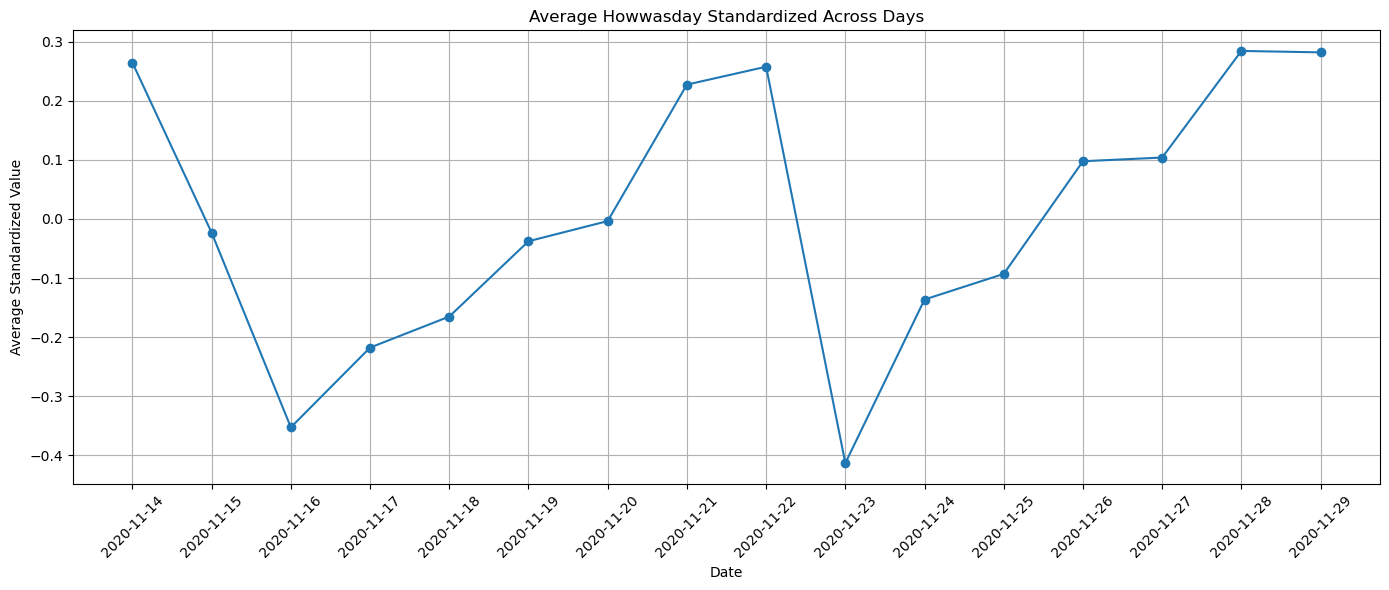

In [135]:
# Group the DataFrame by the 'date' variable and calculate the mean of 'expectday_standardized' and 'howwasday_standardized'
average_per_day = df.groupby('date')[['howwasday_standardized']].mean()

# Reset the index to make 'date' a column again (optional)
average_per_day.reset_index(inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(average_per_day['date'], average_per_day['howwasday_standardized'], label='Average Howwasday Standardized', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Howwasday Standardized Across Days')
plt.xticks(average_per_day['date'], average_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

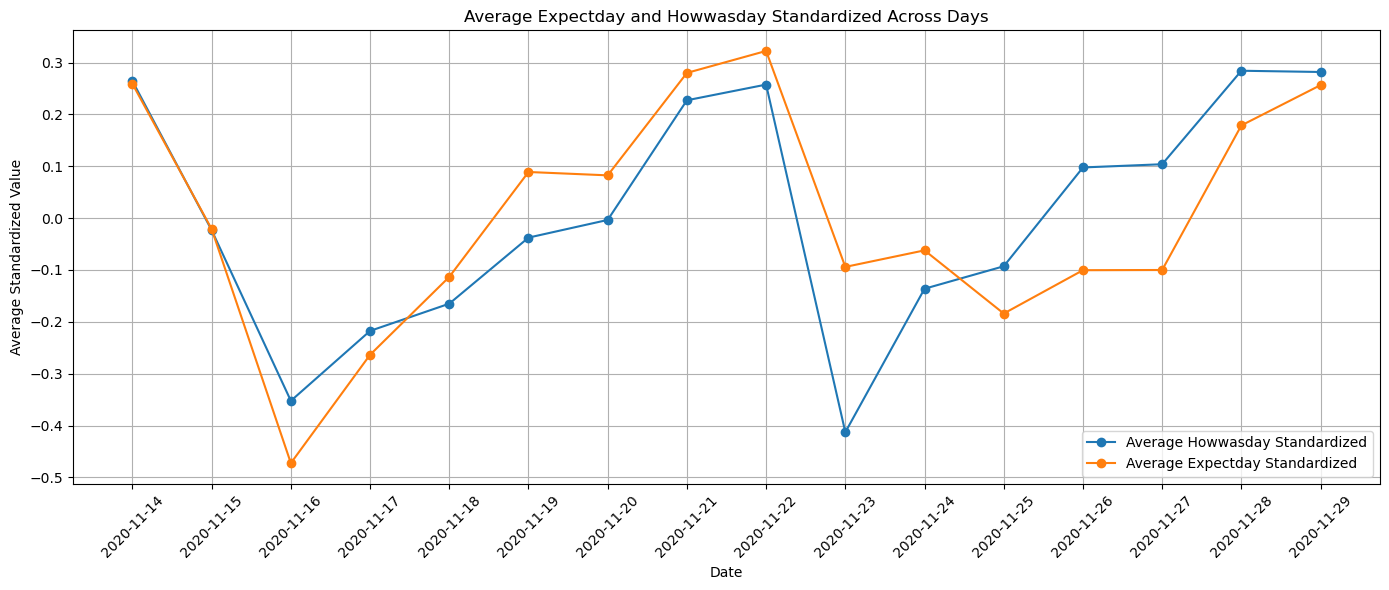

In [136]:
# Group the DataFrame by the 'date' variable and calculate the mean of 'expectday_standardized' and 'howwasday_standardized'
average_per_day = df.groupby('date')[['expectday_standardized', 'howwasday_standardized']].mean()

# Reset the index to make 'date' a column again (optional)
average_per_day.reset_index(inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(average_per_day['date'], average_per_day['howwasday_standardized'], label='Average Howwasday Standardized', marker='o')
plt.plot(average_per_day['date'], average_per_day['expectday_standardized'], label='Average Expectday Standardized', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Expectday and Howwasday Standardized Across Days')
plt.legend()
plt.xticks(average_per_day['date'], average_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

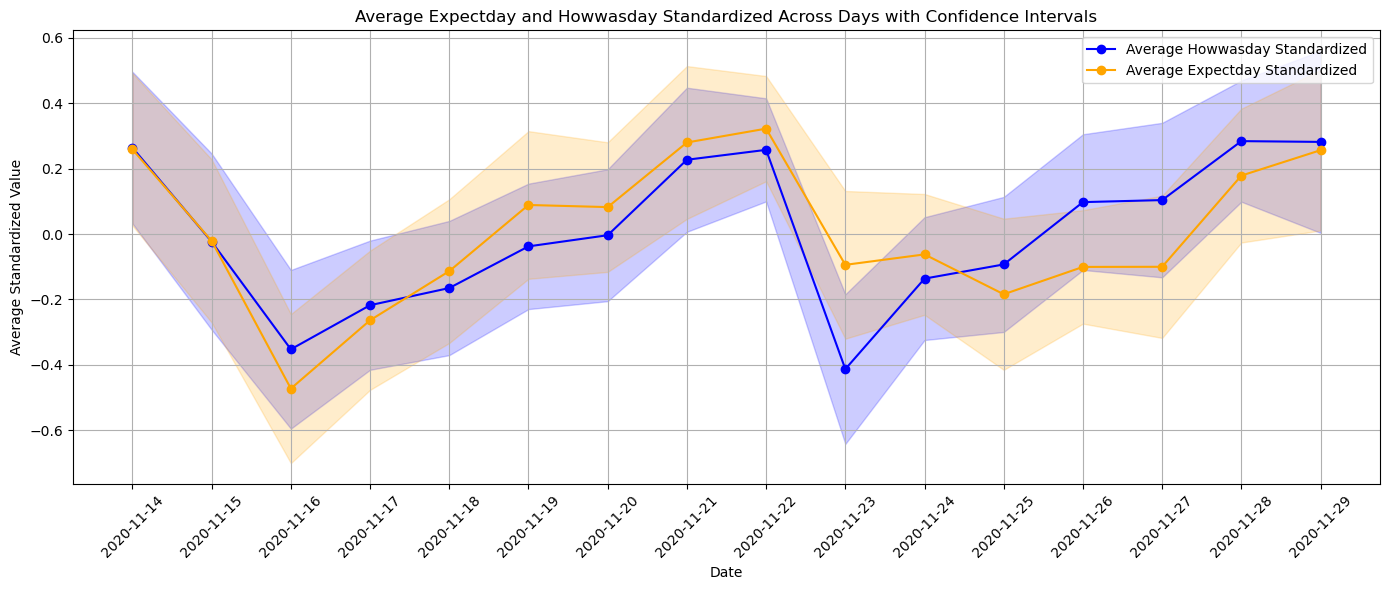

In [137]:
# Group the DataFrame by 'date' and calculate mean and standard error for the two variables
stats_per_day = df.groupby('date')[['expectday_standardized', 'howwasday_standardized']].agg(
    mean_expectday=('expectday_standardized', 'mean'),
    se_expectday=('expectday_standardized', lambda x: np.std(x) / np.sqrt(len(x))),
    mean_howwasday=('howwasday_standardized', 'mean'),
    se_howwasday=('howwasday_standardized', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

# Calculate confidence intervals (95% CI = mean ± 1.96 * standard error)
stats_per_day['ci_lower_expectday'] = stats_per_day['mean_expectday'] - 1.96 * stats_per_day['se_expectday']
stats_per_day['ci_upper_expectday'] = stats_per_day['mean_expectday'] + 1.96 * stats_per_day['se_expectday']
stats_per_day['ci_lower_howwasday'] = stats_per_day['mean_howwasday'] - 1.96 * stats_per_day['se_howwasday']
stats_per_day['ci_upper_howwasday'] = stats_per_day['mean_howwasday'] + 1.96 * stats_per_day['se_howwasday']

# Plot the data
plt.figure(figsize=(14, 6))

# Plot mean and confidence interval for 'howwasday_standardized'
plt.plot(stats_per_day['date'], stats_per_day['mean_howwasday'], label='Average Howwasday Standardized', marker='o', color='blue')
plt.fill_between(stats_per_day['date'], stats_per_day['ci_lower_howwasday'], stats_per_day['ci_upper_howwasday'], color='blue', alpha=0.2)

# Plot mean and confidence interval for 'expectday_standardized'
plt.plot(stats_per_day['date'], stats_per_day['mean_expectday'], label='Average Expectday Standardized', marker='o', color='orange')
plt.fill_between(stats_per_day['date'], stats_per_day['ci_lower_expectday'], stats_per_day['ci_upper_expectday'], color='orange', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Expectday and Howwasday Standardized Across Days with Confidence Intervals')
plt.legend()
plt.xticks(stats_per_day['date'], stats_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

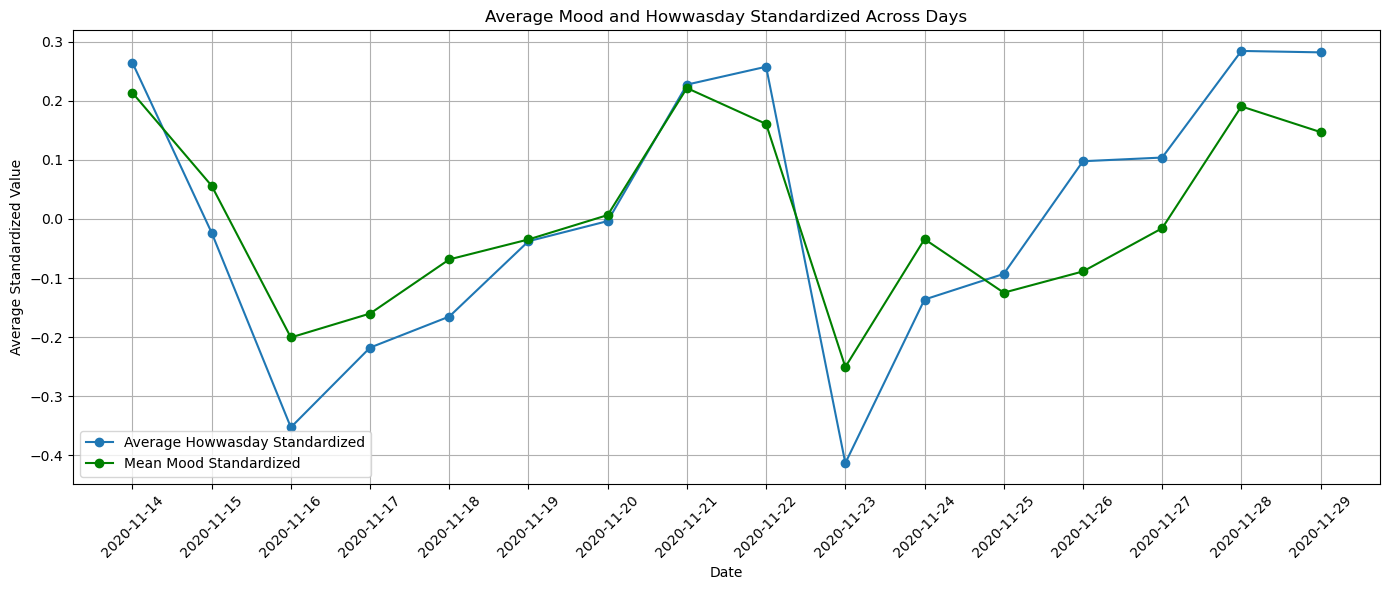

In [138]:
# Group the DataFrame by the 'date' variable and calculate the mean of 'expectday_standardized' and 'howwasday_standardized'
average_per_day = df.groupby('date')[['mean_mood', 'howwasday_standardized']].mean()

# Reset the index to make 'date' a column again (optional)
average_per_day.reset_index(inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(average_per_day['date'], average_per_day['howwasday_standardized'], label='Average Howwasday Standardized', marker='o')
plt.plot(average_per_day['date'], average_per_day['mean_mood'], label='Mean Mood Standardized', marker='o', color='green')
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Mood and Howwasday Standardized Across Days')
plt.legend()
plt.xticks(average_per_day['date'], average_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

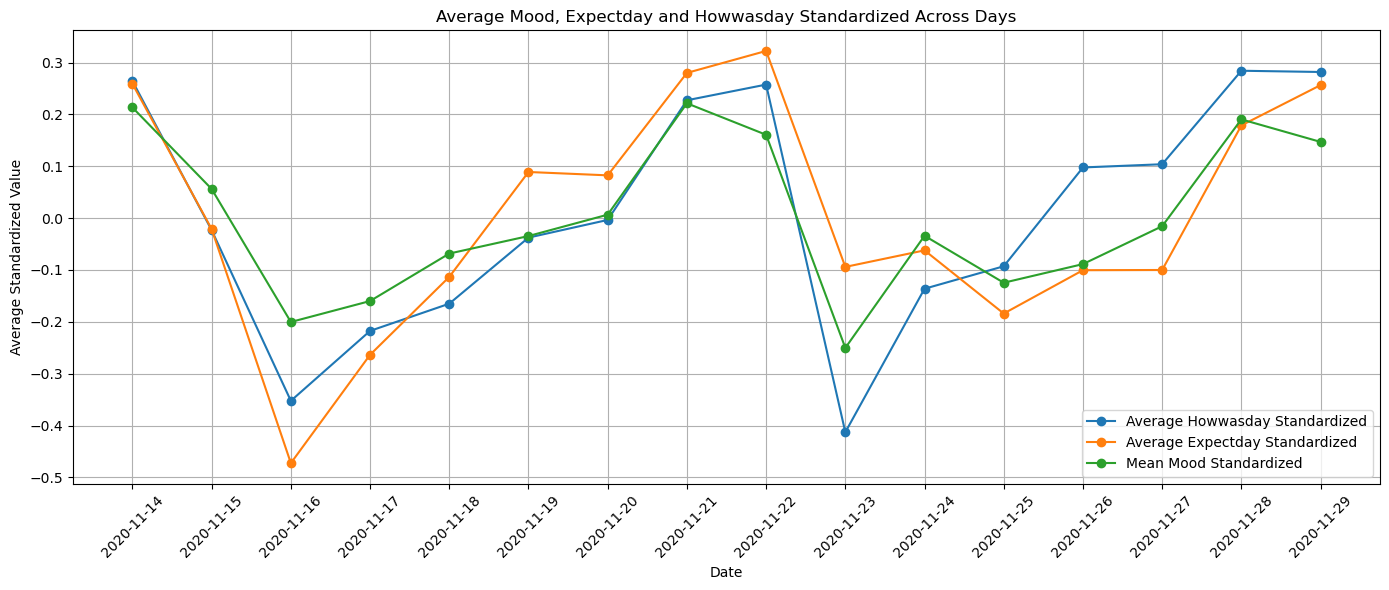

In [139]:
# Group the DataFrame by the 'date' variable and calculate the mean of 'expectday_standardized' and 'howwasday_standardized'
average_per_day = df.groupby('date')[['expectday_standardized', 'howwasday_standardized', 'mean_mood']].mean()

# Reset the index to make 'date' a column again (optional)
average_per_day.reset_index(inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(average_per_day['date'], average_per_day['howwasday_standardized'], label='Average Howwasday Standardized', marker='o')
plt.plot(average_per_day['date'], average_per_day['expectday_standardized'], label='Average Expectday Standardized', marker='o')
plt.plot(average_per_day['date'], average_per_day['mean_mood'], label='Mean Mood Standardized', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Mood, Expectday and Howwasday Standardized Across Days')
plt.legend()
plt.xticks(average_per_day['date'], average_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
len(df)

1162

In [141]:
df.id.nunique()

85

In [142]:
df.columns

Index(['id', 'date', 'expectday', 'howwasday', 'expectday_numeric',
       'howwasday_numeric', 'expectday_standardized', 'howwasday_standardized',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself',
       'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen',
       'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal',
       'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic',
       'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal',
       'Intrapersonal', 'Environmental', 'Spiritual', 'mean_mood', 'max_mood',
       'min_mood', 'mean_mood_morning', 'max_mood_morning', 'min_mood_morning',
       'mean_mood_afternoon', 'max_mood_afternoon', 'min_mood_afternoon',
       'mean_mood_evening', 'max_mood_evening', 'min_mood_evening',
       'gender_Female', 'gender_Male', 'department_Business/economics',
       'department_Engine

In [143]:
# Calculate VIF for each feature
X = df[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself',
       'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen',
       'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal',
       'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic',
       'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal',
       'Intrapersonal', 'Environmental', 'Spiritual']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

             Variable        VIF
12           Pachieve  18.691924
23         Pexistence  16.969920
4            Openness   9.969571
17          Pselftran   8.171720
9               Pself   5.427176
14          Psecurity   3.445664
1       Agreeableness   3.392768
29            Musical   2.762107
33          Spiritual   2.487147
21       Pinteractive   2.215926
7              Pbenov   2.000559
26          Logicmath   0.886103
13             Ppower   0.842812
25         Linguistic   0.833783
2   Conscientiousness   0.820107
3         Neuroticism   0.552129
16           Pselfenh   0.411534
28          Bodykines   0.387849
20     Psuprapersonal   0.377954
24         Pnormative   0.196668
18           Pconserv   0.185190
30      Interpersonal   0.156058
22         Ppromotion   0.113655
19       Pexcitements   0.070442
27            Spatial   0.069125
10              Pstim   0.064903
32      Environmental   0.061151
11             Phedon   0.058322
31      Intrapersonal   0.055581
15        

In [144]:
# Calculate VIF for each feature
X = df[['expectday_numeric', 'mean_mood', 'max_mood', 'min_mood', 'mean_mood2']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

            Variable       VIF
0  expectday_numeric  3.254536
3           min_mood  2.747196
2           max_mood  2.359056
1          mean_mood  1.673074
4         mean_mood2  1.348847


In [145]:
# Calculate VIF for each feature
X = df[['gender_Male', 'department_Engineering and Applied Sciences', 'department_Humanities', 'department_Law', 
                    'department_Medicine and veterinary medicine', 'department_Natural Sciences', 'department_Social Sciences',
                    'cohort_19', 'cohort_20', 'cohort_21', 'cohort_22', 'cohort_23', 'cohort_24', 'cohort_25-26', 'cohort_27+', 
                    'residence_Close to the city where the university is located (less than 1.30 hours of travel).',
                    'residence_In another city away from where the university is located (more than 1.30 hours of travel)',
                    'residence_Rovereto', 'day_of_week_Friday','day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
                    'day_of_week_Tuesday', 'day_of_week_Wednesday']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

                                             Variable       VIF
1         department_Engineering and Applied Sciences  3.680317
5                         department_Natural Sciences  3.088771
6                          department_Social Sciences  3.077427
9                                           cohort_21  2.875557
8                                           cohort_20  2.872648
7                                           cohort_19  2.766697
3                                      department_Law  2.521574
11                                          cohort_23  2.371525
10                                          cohort_22  2.369993
0                                         gender_Male  2.299351
19                               day_of_week_Saturday  2.206256
20                                 day_of_week_Sunday  2.135759
13                                       cohort_25-26  2.081675
12                                          cohort_24  1.903683
2                               departme

In [146]:
df.to_csv('C:/Users/39348/Downloads/data/df_dataset2.csv', index=False)

In [147]:
df_workday.to_csv('C:/Users/39348/Downloads/data/df_workday_dataset2.csv', index=False)

In [148]:
df_holiday.to_csv('C:/Users/39348/Downloads/data/df_holiday_dataset2.csv', index=False)

In [59]:
pd.set_option('display.max_rows', None)

In [ ]:
pd.reset_option('display.max_rows')